In [15]:
#!pip install geopandas
#!pip install geopy
#!pip install pgeocode
#!pip install seaborn
!pip install haversine

In [250]:
from setup import *
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# setup.file_pre_processing()

In [158]:
crime_data = pd.read_csv('crime_data_post_processing.csv', index_col=0)
hospitals = pd.read_csv('hospitals_data_post_processing.csv', index_col=0)

In [159]:
crime_data.head()

,county_name,crime_rate_per_100000,MURDER,RAPE,ROBBERY,AGASSLT,BURGLRY,LARCENY,population,lat_long
0,"St. Louis city, MO",1791.995377,119,200,1778,3609,4995,13791,318416,"(29.6993748, -91.20677)"
1,"Crittenden County, AR",1754.914968,8,38,165,662,1482,1753,49746,"(35.2505701, -90.3192299)"
2,"Alexander County, IL",1664.700485,1,2,5,119,82,184,7629,"(37.1801529, -89.3502834)"
3,"Kenedy County, TX",1456.310680,0,3,1,2,5,4,412,"(27.221984, -97.79136)"
4,"De Soto Parish, LA",1447.402430,3,4,17,368,149,494,27083,"(31.901498, -93.670989)"


In [160]:
hospitals.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)"
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Below the national average,Same as the national average,Same as the national average,2505 U S HIGHWAY 431 NORTH BOAZ AL 35957,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)"
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)"
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)"


In [161]:
print(len(hospitals))

4812


In [162]:
print(len(crime_data))

3136


In [163]:
#drop null lat long hosp. and crime
hospitals = hospitals[hospitals['lat_long'].notna()]
print(len(hospitals))



3928


In [164]:
crime_data = crime_data[crime_data['lat_long'] != "(Na,Na)"]
print(len(crime_data))

3130


In [165]:
import pgeocode
nomi = pgeocode.Nominatim('US')

In [166]:
#!pip install haversine
print(type(hospitals.loc[0]['lat_long']))

<class 'str'>


In [167]:

import ast
hospitals['lat_long'] = hospitals['lat_long'].apply(lambda x : ast.literal_eval(x))
crime_data['lat_long'] = crime_data['lat_long'].apply(lambda x : ast.literal_eval(x))

In [168]:
print(type(hospitals.loc[0]['lat_long']))

<class 'tuple'>


In [169]:
from haversine import haversine, Unit

def find_hospital_closest_county(hospital_lat_long):
    
    minimum = float('inf')
    index_of_minimum = 0
    for i, county_lat_long in enumerate(crime_data['lat_long'].tolist()):

        distance = haversine(hospital_lat_long, county_lat_long, unit=Unit.MILES)
        if distance < minimum:
            minimum = distance
            index_of_minimum = i
    
    return (crime_data.iloc[index_of_minimum]['county_name'], minimum)

In [170]:
# 18.2s: %timeit hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].map(find_hospital_closest_county))
# 18.2s: %timeit hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].apply(find_hospital_closest_county))
# 17.7s
%timeit hospitals['county'], hospitals['distance_in_miles'] = zip(*hospitals['lat_long'].apply(lambda x : find_hospital_closest_county(x)))

19.4 s ± 536 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
hospitals['county']

0           Houston County, AL
2        Lauderdale County, AL
3         Covington County, AL
4          Crenshaw County, AL
5         Jefferson County, GA
                 ...          
4804    San Jacinto County, TX
4805          Worth County, MO
4806      Van Zandt County, TX
4807          Jones County, TX
4809     Assumption Parish, LA
Name: county, Length: 3928, dtype: object

In [172]:
hospitals['distance_in_miles']

0          8.140765
2          7.637646
3         13.809160
4          3.619856
5          9.474224
           ...     
4804      17.258489
4805       7.650199
4806      10.715789
4807       6.943816
4809    1324.743150
Name: distance_in_miles, Length: 3928, dtype: float64

In [173]:
len(hospitals)

3928

In [174]:
hospitals = hospitals.drop(hospitals[hospitals['distance_in_miles'] > 50].index)

In [175]:
len(hospitals)

3901

In [176]:
hospitals.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county,distance_in_miles
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)","Houston County, AL",8.140765
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)","Lauderdale County, AL",7.637646
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)","Covington County, AL",13.809160
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)","Crenshaw County, AL",3.619856
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Below the national average,Below the national average,50 MEDICAL PARK EAST DRIVE BIRMINGHAM AL 35235,"(33.595315299999996, -86.66763066940506)","Jefferson County, GA",9.474224


In [177]:
hospitals['county'].value_counts()

Los Angeles County, CA       69
Granite County, MT           27
Orange County, CA            21
Orange County, VA            18
San Bernardino County, CA    18
                             ..
Okeechobee County, FL         1
Conecuh County, AL            1
Loving County, TX             1
Floyd County, IA              1
Cumberland County, NC         1
Name: county, Length: 2030, dtype: int64

In [178]:
hospitals[hospitals['county']=="St. Louis city, MO"]

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county,distance_in_miles
1773,190014,TECHE REGIONAL MEDICAL CENTER,1125 MARGUERITE STREET,MORGAN CITY,LA,70380,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Same as the national average,Same as the national average,1125 MARGUERITE STREET MORGAN CITY LA 70380,"(29.70862435, -91.20093572063564)","St. Louis city, MO",0.728715


In [180]:
hospitals = hospitals[hospitals['Hospital overall rating']!='Not Available']
hospitals

,Provider ID,Hospital Name,Address,City,State,ZIP Code,Hospital Type,Hospital Ownership,Emergency Services,Hospital overall rating,Mortality national comparison,Patient experience national comparison,Effectiveness of care national comparison,full_address,lat_long,county,distance_in_miles
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,Acute Care Hospitals,Government - Hospital District or Authority,Yes,3,Same as the national average,Below the national average,Same as the national average,1108 ROSS CLARK CIRCLE DOTHAN AL 36301,"(31.216402000000002, -85.36564064472296)","Houston County, AL",8.140765
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,Acute Care Hospitals,Government - Hospital District or Authority,Yes,2,Below the national average,Below the national average,Same as the national average,205 MARENGO STREET FLORENCE AL 35631,"(34.7946245, -87.68303582998244)","Lauderdale County, AL",7.637646
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Same as the national average,Below the national average,702 N MAIN ST OPP AL 36467,"(31.2928787, -86.25490030241093)","Covington County, AL",13.809160
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Not Available,Same as the national average,101 HOSPITAL CIRCLE LUVERNE AL 36049,"(31.6937493, -86.26470160380265)","Crenshaw County, AL",3.619856
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,Acute Care Hospitals,Voluntary non-profit - Private,Yes,2,Same as the national average,Below the national average,Below the national average,50 MEDICAL PARK EAST DRIVE BIRMINGHAM AL 35235,"(33.595315299999996, -86.66763066940506)","Jefferson County, GA",9.474224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4779,670080,SETON MEDICAL CENTER HARKER HEIGHTS,850 W CENTRAL TEXAS EXPRESSWAY,HARKER HEIGHTS,TX,76548,Acute Care Hospitals,Proprietary,Yes,4,Same as the national average,Above the national average,Same as the national average,850 W CENTRAL TEXAS EXPRESSWAY HARKER HEIGHTS ...,"(31.07255555, -97.68263831469964)","Coryell County, TX",25.371775
4780,670082,BAYLOR SCOTT AND WHITE MEDICAL CENTER MCKINNEY,5252 WEST UNIVERSITY DRIVE,MC KINNEY,TX,75071,Acute Care Hospitals,Voluntary non-profit - Private,Yes,4,Same as the national average,Above the national average,Same as the national average,5252 WEST UNIVERSITY DRIVE MC KINNEY TX 75071,"(33.2196077, -96.68214955013056)","Kinney County, TX",6.012212
4784,670088,BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...,700 SCOTT & WHITE DRIVE,COLLEGE STATION,TX,77845,Acute Care Hospitals,Voluntary non-profit - Private,Yes,4,Same as the national average,Above the national average,Same as the national average,700 SCOTT & WHITE DRIVE COLLEGE STATION TX 77845,"(30.582118100000002, -96.27948966825502)","Burleson County, TX",24.886731
4787,670092,WALNUT HILL MEDICAL CENTER,7502 GREENVILLE AVENUE,DALLAS,TX,75231,Acute Care Hospitals,Proprietary,Yes,3,Same as the national average,Below the national average,Same as the national average,7502 GREENVILLE AVENUE DALLAS TX 75231,"(32.8763542, -96.75192719885766)","Dawson County, TX",2.831800


In [203]:
hospitals['Hospital overall rating']=hospitals['Hospital overall rating'].astype(int)


In [204]:
hospitals.iloc[0]['Hospital overall rating']

3

In [219]:
hosp_grouped = hospitals.groupby('county')
hospital_mean_rating_by_county = hosp_grouped['Hospital overall rating'].mean()
hospital_mean_rating_by_county

county
Abbeville County, SC    3.666667
Acadia Parish, LA       3.333333
Adair County, KY        3.000000
Adair County, OK        4.000000
Adams County, IN        3.000000
                          ...   
York County, SC         4.000000
York County, VA         1.000000
Yuba County, CA         2.000000
Yuma County, AZ         2.000000
Yuma County, CO         3.000000
Name: Hospital overall rating, Length: 1634, dtype: float64

In [ ]:
hospital_mean_rating_by_county

In [294]:
#get countys with avg. rating of 5 and avg. rating of 1
top_rated_counties = hospital_mean_rating_by_county[hospital_mean_rating_by_county==5.0].index
top_rated_counties


Index(['Craven County, NC', 'Dubois County, IN', 'Emmet County, MI',
       'Gillespie County, TX', 'Houston County, GA', 'Jackson County, IN',
       'La Plata County, CO', 'Lincoln County, SD', 'Madison County, IA',
       'Morgan County, GA', 'Newport County, RI', 'Newton County, GA',
       'Winston County, AL'],
      dtype='object', name='county')

In [301]:
lowest_rated_counties = hospital_mean_rating_by_county[hospital_mean_rating_by_county==1.0].index

In [279]:
lowest_rated_counties

Index(['Banks County, GA', 'Bronx County, NY', 'Irwin County, GA',
       'Pittsylvania County, VA', 'Santa Cruz County, AZ', 'Sumner County, KS',
       'Sutter County, CA', 'York County, VA'],
      dtype='object', name='county')

In [295]:
crime_for_highest_rated=[]
counties_highest_rated=[]

for county in top_rated_counties:
    counties_highest_rated.append(county)
    crime_for_highest_rated.append(crime_data[crime_data['county_name']==county]['crime_rate_per_100000'].values[0])

In [304]:
crime_for_lowest_rated=[]
counties_lowest_rated=[]
for county in lowest_rated_counties:
    counties_lowest_rated.append(county)
    crime_for_lowest_rated.append(crime_data[crime_data['county_name']==county]['crime_rate_per_100000'].values[0])

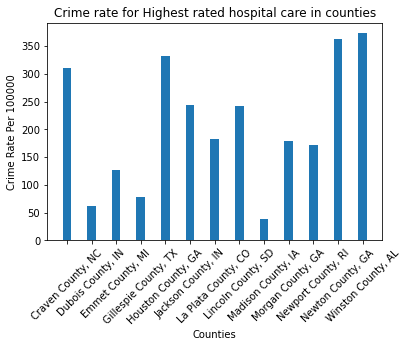

In [307]:
width = 0.35
fig, ax = plt.subplots()
ax.bar(counties_highest_rated, crime_for_highest_rated, width)
ax.set_ylabel('Crime Rate Per 100000')
ax.set_xlabel('Counties')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Crime rate for Highest rated hospital care in counties')

plt.show()

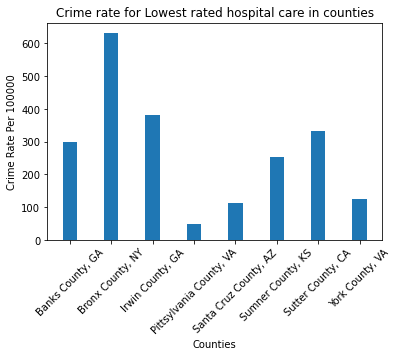

In [306]:

fig, ax = plt.subplots()
ax.bar(counties_lowest_rated, crime_for_lowest_rated, width)
ax.set_ylabel('Crime Rate Per 100000')
ax.set_xlabel('Counties')
ax.tick_params(axis='x', rotation=45)
ax.set_title('Crime rate for Lowest rated hospital care in counties')

plt.show()

## Problem Statement
My goal with this notebook is to use to answer the question: *is class positively correlated with survival on the ship Titanic?*

## Data

To answer this question I will use a dataset from Kaggle called titanic 
(link here: [titanic dataset](https://www.kaggle.com/c/titanic)). I collected this by downloading the csv. The data is stored in a csv format. There are 891 rows and 12 columns. The total size of the file is 59 kB. 

## Data cleaning and manipulation

To address my central question I did the following data cleaning steps:
    ....
    
This are all contained in the file data_cleaning_functions.py. 

## Analysis

To present my analysis I first consider a table of survival rates for each class. Here I can see that the proportion of passengers in the first class who survived is much higher than for the second and third classes. 

However, it is possible that this gap is not trustworthy if there is very little data in one of these classes. So I will also plot survival and include the size of the category in the plot. 

In the plot although we can see there is more data in the third class the amount of data in the first class is not so small that I am concerned. I do think there is a statistically valid relationship between class and survival. However, to be triple sure, I'll check the correlation coefficient between plcass and survival rate and check that it is statistically significant. 

Surprisingly, although the correlation coefficient is very strong negative, it is not statistically signifanct (probably because I only have three values and have lost all information about the size of the data). 


Now I see a weaker but much more significant relationship between the two variables. However, it the pearson correlation coefficient isn't really set up for this kind of comparison, so in future work I will use a better measure. 

## Take-aways
For now, I am convinced that as class goes up from 3 -> 1 there is an increase in survival rates. While the relationship is strong and seems to be significant, I will test the significant levels more thoroughly in future work.  

## References 

Include all references to sources for the code, sources for any packages or methods you used and a guide to all of the files you wrote and are including. 